# Pytorch starter - FasterRCNN Train
In this notebook I enabled the GPU and the Internet access (needed for the pre-trained weights). We can not use Internet during inference, so I'll create another notebook for commiting. Stay tuned!

You can find the [inference notebook here](https://www.kaggle.com/pestipeti/pytorch-starter-fasterrcnn-inference)

- FasterRCNN from torchvision
- Use Resnet50 backbone
- Albumentation enabled (simple flip for now)


In [1]:
import pandas as pd
import numpy as np
import cv2
import os
import re
from collections import defaultdict


from PIL import Image

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import torch
import torchvision
import torchvision.transforms.functional as FT

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler

from matplotlib import pyplot as plt
from torchvision.ops.boxes import box_iou

DIR_INPUT = '/media/jake/mark-4tb3/input/kaggle_4tb/global-wheat-detection'
DIR_TRAIN = f'{DIR_INPUT}/train'
DIR_TEST = f'{DIR_INPUT}/test'
%load_ext autotime

In [2]:
train_df = pd.read_csv(f'{DIR_INPUT}/train.csv')
train_df.shape

(147793, 5)

time: 101 ms


In [3]:
CUDA_VISIBLE_DEVICES=1

time: 253 µs


In [4]:
train_df

,image_id,width,height,bbox,source
0,b6ab77fd7,1024,1024,"[834.0, 222.0, 56.0, 36.0]",usask_1
1,b6ab77fd7,1024,1024,"[226.0, 548.0, 130.0, 58.0]",usask_1
2,b6ab77fd7,1024,1024,"[377.0, 504.0, 74.0, 160.0]",usask_1
3,b6ab77fd7,1024,1024,"[834.0, 95.0, 109.0, 107.0]",usask_1
4,b6ab77fd7,1024,1024,"[26.0, 144.0, 124.0, 117.0]",usask_1
...,...,...,...,...,...
147788,5e0747034,1024,1024,"[64.0, 619.0, 84.0, 95.0]",arvalis_2
147789,5e0747034,1024,1024,"[292.0, 549.0, 107.0, 82.0]",arvalis_2
147790,5e0747034,1024,1024,"[134.0, 228.0, 141.0, 71.0]",arvalis_2
147791,5e0747034,1024,1024,"[430.0, 13.0, 184.0, 79.0]",arvalis_2


time: 15.2 ms


In [5]:
train_df['x'] = -1
train_df['y'] = -1
train_df['w'] = -1
train_df['h'] = -1

def expand_bbox(x):
    r = np.array(re.findall("([0-9]+[.]?[0-9]*)", x))
    if len(r) == 0:
        r = [-1, -1, -1, -1]
    return r

train_df[['x', 'y', 'w', 'h']] = np.stack(train_df['bbox'].apply(lambda x: expand_bbox(x)))
train_df.drop(columns=['bbox'], inplace=True)
train_df['x'] = train_df['x'].astype(np.float)
train_df['y'] = train_df['y'].astype(np.float)
train_df['w'] = train_df['w'].astype(np.float)
train_df['h'] = train_df['h'].astype(np.float)

time: 889 ms


In [6]:
image_ids = train_df['image_id'].unique()
valid_num = -20
valid_ids = image_ids[valid_num:]
train_ids = image_ids[:valid_num]

time: 4.44 ms


In [7]:
valid_df = train_df[train_df['image_id'].isin(valid_ids)]
train_df = train_df[train_df['image_id'].isin(train_ids)]

time: 18.8 ms


In [8]:
valid_df.shape, train_df.shape

((423, 8), (147370, 8))

time: 2.31 ms


In [9]:
class WheatDataset(Dataset):

    def __init__(self, dataframe, image_dir, transforms=None):
        super().__init__()

        self.image_ids = dataframe['image_id'].unique()
        self.df = dataframe
        self.image_dir = image_dir
        self.transforms = transforms

    def __getitem__(self, index: int):

        image_id = self.image_ids[index]
        records = self.df[self.df['image_id'] == image_id]

        image = cv2.imread(f'{self.image_dir}/{image_id}.jpg', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0

        #true_boxes = np.array([[i[0],i[1],i[0]+i[2],i[1]+i[3]] for i in true_boxes])
        boxes = records[['x', 'y', 'w', 'h']].values
        boxes[:, 2] = boxes[:, 0] + boxes[:, 2]
        boxes[:, 3] = boxes[:, 1] + boxes[:, 3]
        
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        area = torch.as_tensor(area, dtype=torch.float32)

        # there is only one class
        labels = torch.ones((records.shape[0],), dtype=torch.int64)
        
        # suppose all instances are not crowd
        iscrowd = torch.zeros((records.shape[0],), dtype=torch.int64)
        
        target = {}
        #print('boxesA->',boxes)
        target['boxes'] = boxes
        target['labels'] = labels
        # target['masks'] = None
        target['image_id'] = torch.tensor([index])
        target['area'] = area
        target['iscrowd'] = iscrowd

        if self.transforms:
            #print('image->',image.shape,type(image))
            #print('target-boxes->',target['boxes'])
            
            sample = {
                'image': image,
                'bboxes': target['boxes'],
                'labels': labels
            }
            sample = self.transforms(**sample)
            image = sample['image']
            
            target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)

        return image, target, image_id

    def __len__(self) -> int:
        return self.image_ids.shape[0]

time: 4.27 ms


In [10]:
# Albumentations
def get_train_transform():
    return A.Compose([
        A.Flip(0.5),
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

def get_valid_transform():
    return A.Compose([
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})


time: 1.29 ms


# Create the model

In [11]:
# load a model; pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

time: 546 ms


In [13]:
num_classes = 2  # 1 class (wheat) + background

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

time: 1.83 ms


In [14]:
class Averager:
    def __init__(self):
        self.current_total = 0.0
        self.iterations = 0.0

    def send(self, value):
        self.current_total += value
        self.iterations += 1

    @property
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.current_total / self.iterations

    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0


time: 1.32 ms


In [15]:
def collate_fn(batch):
    return tuple(zip(*batch))

train_dataset = WheatDataset(train_df, DIR_TRAIN, get_train_transform())
valid_dataset = WheatDataset(valid_df, DIR_TRAIN, get_valid_transform())


# split the dataset in train and test set
indices = torch.randperm(len(train_dataset)).tolist()

train_data_loader = DataLoader(
    train_dataset,
    batch_size=8,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)

valid_data_loader = DataLoader(
    valid_dataset,
    batch_size=8,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)

time: 9.85 ms


In [16]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

time: 45.9 ms


# Sample

In [17]:
images, targets, image_ids = next(iter(train_data_loader))
#images = list(image.to(device) for image in images)
#targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

time: 806 ms


In [18]:
boxes = targets[0]['boxes'].cpu().numpy().astype(np.int32)
sample = images[0].permute(1,2,0).cpu().numpy()

time: 1.22 ms


In [19]:
boxes

array([[ 134,  222,  190,  258],
       [ 668,  548,  798,  606],
       [ 573,  504,  647,  664],
       [  81,   95,  190,  202],
       [ 874,  144,  998,  261],
       [ 336,  382,  455,  493],
       [ 890,  602,  972,  647],
       [ 275,  302,  397,  377],
       [ 544,  367,  612,  449],
       [  15,  220,   71,  323],
       [ 868,   70,  994,  203],
       [ 943,  541,  989,  587],
       [ 804,   60,  921,  143],
       [ 497,    4,  607,   95],
       [ 141,  299,  260,  392],
       [ 427,   58,  485,  188],
       [ 764,  274,  885,  350],
       [ 445,  634,  563,  698],
       [ 696,  634,  809,  709],
       [ 763,  903,  890,  952],
       [ 200,  545,  287,  593],
       [ 689,  930,  732,  976],
       [ 938,  827, 1024,  885],
       [ 643,   44,  700,  114],
       [ 245,  794,  361,  858],
       [ 623,  730,  699,  802],
       [ 795,  554,  869,  624],
       [ 171,  833,  241,  924],
       [ 417,   46,  490,  270],
       [ 763,  281,  869,  419],
       [ 8

time: 6.08 ms


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


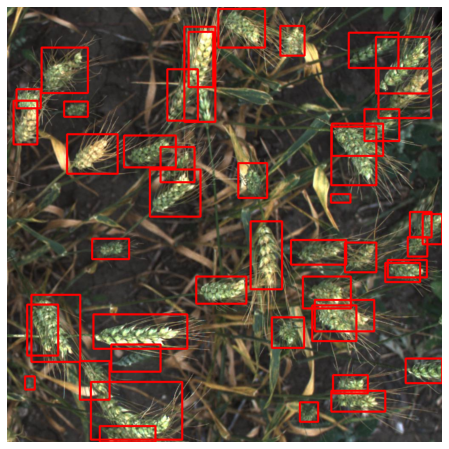

time: 246 ms


In [20]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in boxes:
    cv2.rectangle(sample,
                  (box[0], box[1]),
                  (box[2], box[3]),
                  (220, 0, 0), 3)
    
ax.set_axis_off()
ax.imshow(sample)

# MAP

In [21]:
def make_input_image(img_path,input_size):
    image_arr = cv2.imread(img_path, cv2.IMREAD_COLOR)
    image_arr = cv2.cvtColor(image_arr, cv2.COLOR_BGR2RGB).astype(np.float32)
    image_arr /= 255.0
    new_image = image_arr

    new_image = FT.to_tensor(new_image)
    new_image = FT.to_pil_image(new_image)
    new_image = FT.resize(new_image, (input_size, input_size))
    new_image = FT.to_tensor(new_image)
    new_image = FT.to_pil_image(new_image)
    new_image_model = FT.to_tensor(np.array(new_image)).cuda()
    return new_image_model


def calculate_precision(boxes_true: torch.tensor, boxes_pred: torch.tensor, confidences: list, threshold=0.5) -> float:
    """Calculates precision for GT - prediction pairs at one threshold."""
    #print('boxes_true->',boxes_true)
    confidences = np.array(confidences)

    # edge case for no ground truth boxes
    #print('calculate_precision_boxes_true->',boxes_true)
    if boxes_true.size(1) == 0:
        return 0.

    #print('boxes_pred',boxes_pred.cpu())
    #print('boxes_true',boxes_true.cpu())
    #boxes_pred.cpu()
    #boxes_true.cpu()
    #print('boxes_pred->',boxes_pred)
    #print('boxes_true->?',boxes_true)
    iou = box_iou(boxes1=boxes_pred, boxes2=boxes_true)

    pr_matches = set()
    gt_matches = set()

    # for each ground truth box, get list of pred boxes it matches with
    match_candidates = (iou >= threshold).nonzero()
    GT_PR_matches = defaultdict(list)
    for PR, GT in match_candidates:
        GT_PR_matches[GT.item()].append(PR.item())

    # Find which pred matches a GT box
    for GT, PRs in GT_PR_matches.items():
        # if multiple preds match a single ground truth box,
        # select the pred with the highest confidence
        if len(PRs) > 1:
            pr_match = PRs[confidences[PRs].argsort()[-1]]
        # else only a single pred matches this GT box
        else:
            pr_match = PRs[0]

        # only if we haven't seen a pred before can we mark a PR-GT pair as TP
        # otherwise the pred matches a different GT box and this GT might instead be a FN
        if pr_match not in pr_matches:
            gt_matches.add(GT)

        pr_matches.add(pr_match)

    TP = len(pr_matches)

    pr_idx = range(iou.size(0))
    gt_idx = range(iou.size(1))

    FP = len(set(pr_idx).difference(pr_matches))
    FN = len(set(gt_idx).difference(gt_matches))

    return TP / (TP + FP + FN)


def calculate_mean_precision(boxes_true: torch.tensor, boxes_pred: torch.tensor, confidences: np.array,
                             thresholds=(0.5,)):
    """Calculates average precision over a set of thresholds"""

    precision = np.zeros(len(thresholds))

    for i, threshold in enumerate(thresholds):
        precision[i] = calculate_precision(boxes_true=boxes_true, boxes_pred=boxes_pred, confidences=confidences,
                                           threshold=threshold)
    return precision.mean()

time: 4.63 ms


In [22]:
PATH = '/media/jake/mark-4tb3/input/kaggle_4tb/global-wheat-detection/weights/weat.pth'

def mean_average_precision():
    #print('mean_average_precision')
    # input_size = 300
    batch_size = 1
    dataset_num = 83

    data_folder = '/media/jake/mark-4tb3/input/kaggle_4tb/global-wheat-detection/'
    checkpoint_fpath = '/media/jake/mark-4tb3/input/kaggle_4tb/global-wheat-detection/weights/fasterrcnn_resnet50_fpn.pth'
    #valid_dataset = BalloonDataset(data_folder, split='test', dataset_num=dataset_num, input_size=input_size)
    valid_dataset = WheatDataset(valid_df, DIR_TRAIN, get_valid_transform())
    weight_path = checkpoint_fpath

    csv_path =data_folder + 'train.csv'
    path = data_folder + 'train/'

    ##predict boxes
    valid_data_loader = DataLoader(
        valid_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=4,
        collate_fn=collate_fn
    )

    image_num = 0
    mean_precisions = []
    
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)  
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

    num_classes = 2
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    model.to(device)
    # Load the trained weights
    model.load_state_dict(torch.load('/media/jake/mark-4tb3/input/kaggle_4tb/global-wheat-detection/weights/fasterrcnn_resnet50_fpn.pth'))
    model.eval()#x = model.to(device)

    for images, targets, image_ids  in valid_data_loader:

        
        images = list(img.to(device) for img in images)
        targets = [{k: v for k, v in t.items()} for t in targets]
        outputs = model(images)
        outputs = [{k: v.cpu() for k, v in t.items()} for t in outputs]

        boxes_pred = outputs[0]['boxes']
        confidences = outputs[0]['scores']
        threshold = 0.5

        boxes_pred = boxes_pred[confidences > threshold]
        confidences = confidences[confidences > threshold]

        confidences = list(confidences)
        #box_true_scale = make_true_boxes_new_scale(df, image_num, input_size=input_size)
        targets = targets[0]['boxes']
        #print('pred_boxes->',boxes_pred)
        #print('confidences->',confidences)
        #print('boxes_true->',targets)
        score = calculate_mean_precision(boxes_true=targets, boxes_pred=boxes_pred, confidences=confidences)
        mean_precisions.append(score)
    return np.mean(mean_precisions)

#mean_average_precision(1024)

time: 3.92 ms


# Train

In [23]:
model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
# lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
lr_scheduler = None

num_epochs = 10

time: 1.32 s


In [24]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)  
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

num_classes = 2
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
model.to(device)
# Load the trained weights


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d()
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d()
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d()
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d()
          (relu): ReLU(inplace=True)
          (downsample): Sequent

time: 484 ms


In [25]:
loss_hist = Averager()
itr = 1

for epoch in range(num_epochs):
    loss_hist.reset()
    
    model.load_state_dict(torch.load('/media/jake/mark-4tb3/input/kaggle_4tb/global-wheat-detection/weights/fasterrcnn_resnet50_fpn.pth'))
    model.train()#x = model.to(device)
    
    for images, targets, image_ids in train_data_loader:
        #print('epoch->{}, i->{}'.format(epoch,i))
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)


        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()

        loss_hist.send(loss_value)

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        
        #MAP        
        if itr % 5 == 0:
            #print("=================================================================================")
            score = mean_average_precision()
            
            print(f"Iteration #{itr} loss: {loss_value}, map:{score}%")

            
            weight_path = '/media/jake/mark-4tb3/input/kaggle_4tb/global-wheat-detection/weights/fasterrcnn_resnet50_fpn.pth'
            torch.save(model.state_dict(),weight_path)

        itr += 1
    
    # update the learning rate
    if lr_scheduler is not None:
        lr_scheduler.step()

    print(f"Epoch #{epoch} loss: {loss_hist.value}") 

/home/jake/venv/lib/python3.7/site-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
/pytorch/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple)


Iteration #5 loss: 0.7271561924087436, map:0.647479184083152%
Iteration #10 loss: 0.6982253714612956, map:0.523942678757424%
Iteration #15 loss: 0.6604003010503767, map:0.4607031993469704%
Iteration #20 loss: 0.6353308094436105, map:0.5878106060975488%
Iteration #25 loss: 0.5289544265471366, map:0.6102515227624333%
Iteration #30 loss: 0.9936727037746687, map:0.610429135839737%


KeyboardInterrupt: 

time: 45.4 s


In [ ]:
weight_path = '/media/jake/mark-4tb3/input/kaggle_4tb/global-wheat-detection/weights/fasterrcnn_resnet50_fpn.pth'

In [ ]:
torch.save(model.state_dict(),weight_path)

In [ ]:
model.load_state_dict(torch.load(weight_path))

# save

In [ ]:
loss_hist = Averager()
itr = 1
PATH = '/media/jake/mark-4tb3/input/kaggle_4tb/global-wheat-detection/weights/weat.pth'
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
model.cuda()
for epoch in range(num_epochs):
    loss_hist.reset()
    
    for images, targets, image_ids in train_data_loader:
        
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        #print('model_images->',np.array(images)[0].shape)
        #print('type_images->',type(images))
        #print('targets->',targets)
        loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()

        loss_hist.send(loss_value)

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        if itr % 50 == 0:
            print(f"Iteration #{itr} loss: {loss_value}")
            #score = mean_average_precision(input_size=1024)
            #print('[A]Epoch[{}] MAP:[{}%]'.format(epoch,score))
            #print('save model->')
            torch.save(model.state_dict(),PATH)
        itr += 1
    
    # update the learning rate
    if lr_scheduler is not None:
        lr_scheduler.step()

    print(f"Epoch #{epoch} loss: {loss_hist.value}")   